In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# move into project directory
repo_name = "UMass-CS670-Project"
%cd /content/drive/MyDrive/UMass-Courses/Semester-2/CS670/$repo_name
!ls

/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project
apex	     excluded-train-files.txt  index.py		      SINet.ipynb
common	     experiments	       last_run_info.json     sinet.py
config.yaml  get_dataset.sh	       models		      SINet_r18.ipynb
datautils    get_info.py	       output		      source-data
demo	     github-repo-clone.ipynb   preprocess_dataset.py  test_seg.py
demo.ipynb   Index.ipynb	       README.md	      texture_params.txt


In [3]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

!pip install grad-cam
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#!sudo mv sam_vit_h_4b8939.pth /content/drive/MyDrive/UMass-Courses/Semester-2/CS670/$repo_name/models/weights/sam_vit_h_4b8939.pth


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.3-py3-none-any.whl size=38656 sha256=6aaf0e212450e249791b50e0c8a1e9c11ecccbfab605c6449257a044e63d23c5
  Stored in directory: /root/.cache/pip/wheels/2e/ce/70/fe64f851895eae830b3c63ec7fc464cfa7c81aeb7ad4f68063
Successfully built grad-cam
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pjxqicno
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pjxqicno
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 526fd066dea338ba2ca08886853bd37ffd6a8aec
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha

In [ ]:
#!unzip -qq ./source-data/TestDataset.zip -d ./source-data/

In [3]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
# uncomment the lines below  to download the data

import os

!pip install gdown

data_dir="source-data"

if not(os.path.exists("source-data")):
    !gdown https://drive.google.com/uc?id=1IAd2b7EtPqqXbFF3D9PLsHCDjMnr9UkL&export=download
    #echo 'Downloaded data! Unzipping to data folder'
    !unzip -qq -d . ./COD10K-v3.zip
    os.rename("./COD10K-v3.zip", "./source-data/COD10K-v3.zip")
else:
    print("\nThe data directory exists!")


The data directory exists!


In [4]:
# setup some imports
from datautils.datareader import read_data
from datautils.dataset import COD10KDataset
from torch.utils.data import DataLoader
import random
import numpy as np
import torch
import argparse
from tqdm import tqdm
from torchvision.io import read_image
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image
import json

from experiments.style_transfer import style_transfer, run_style_transfer_pipeline, deep_style_transfer
from common.visualizer import layer_visualizer
from common.utils import init_config

In [5]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [6]:
config_params = init_config()
print(config_params)

{'data_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/source-data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/output', 'root_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project', 'use_gpu': True}




Iteration 0


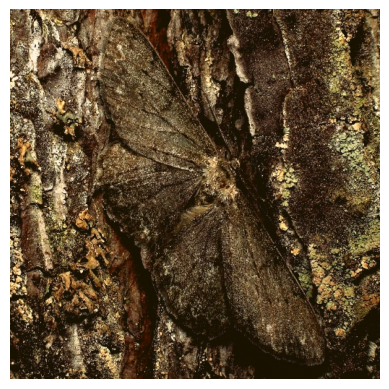



Iteration 99


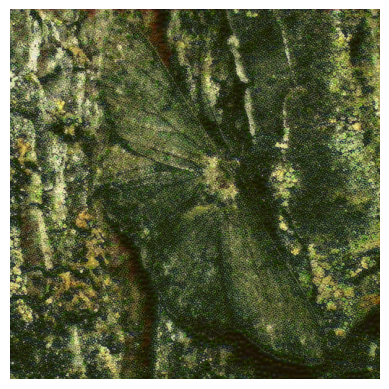



Content loss:  0.004510002210736275 | Style Loss:  0.006695022340863943 | Total variation loss: 3.189656972885132


In [9]:
# @title Try style transfer pipeline on sample images {"vertical-output":true}
content_name = "butterfly-image" # @param ["bgm-bird-1","bgm-bird-2","butterfly-image","fish"]
texture_name = "sand-with-moss" # @param ["moss","sand-with-moss","wet-sand","rain","foliage-texture"]
max_iter = 100 # @param {"type":"integer","placeholder":"100"}


# run style transfer on sample image

param_dict = {
    'moss': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'snow': {
        'epochs': 200,
        'style_weights': 1.5
    },
    'wet-sand': {
        'epochs': 200,
        'style_weights': 3.5
    },
    'sand-with-moss': {
        'epochs': 100,
        'style_weights': 2.5
    },
    'rain': {
        'epochs': 100,
        'style_weights': 4.5
    },
    'wood': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'grass': {
        'epochs': 100,
        'style_weights': 0.1
    },
    'foliage-texture': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'blue-coral': {
        'epochs': 100,
        'style_weights': 1.1
    }
}

with open("./last_run_info.json") as fp:
    last_run = json.load(fp)["last_batch"]

selected_textures = ['moss', 'wet-sand', 'sand-with-moss', 'rain', 'foliage-texture']

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 1)
parser.add_argument('--model_name', type=str, default='vgg')
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--max_iter', type=int, default=max_iter)
parser.add_argument('--iter_interval', type=int, default=50)
parser.add_argument('--texture_name', type=str, default="moss")
parser.add_argument('--content_name', type=str, default="butterfly-image")
args = parser.parse_args(args=[])

style_img = read_image(f'./source-data/Textures/{texture_name}.jpg')
img = read_image(f'./source-data/Mini-Set/{content_name}.jpg')
#img = img[None, :]
#print(img.size())
#layer_visualizer(img, args)
#layer_visualizer(style_img, args)
#style_layers = [1, 6, 11, 20, 29] #[2]
style_layers = [0, 2, 5, 14, 23]
content_layer = 21
style_weights = [param_dict[texture_name]] * 5 #[1.5]*5
content_weight = 1e-4 #1
total_variance_weight = 1e-5 #4
style_transfer(img, style_img, style_layers, content_layer, content_weight, style_weights, total_variance_weight, args)

In [ ]:
'''

#from experiments.deep_style_transfer import main

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import numpy as np
import copy
#from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
#from common.sam_utils import show_mask, show_box
from common.sam_utils import get_sam_mask
from common.closed_form_matting import closed_form_matting_with_mask
from common.utils import get_config
import os

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4_2']
style_layers_default = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

unloader = transforms.ToPILImage()  # reconvert into PIL image

device = get_config()['device']

CHECKPOINT_PATH='./models/weights/sam_vit_h_4b8939.pth'

MODEL_TYPE = "vit_h"


def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

class AugmentedStyleLoss(nn.Module):

    def __init__(self, target_features, style_mask, content_mask):
        super(AugmentedStyleLoss, self).__init__()
        #self.input_masks = [mask.detach() for mask in input_masks]
        self.content_mask = content_mask.detach()
        #print('augmented style loss feature size', target_features[0].size(), style_mask.size())
        #print('inp devices', target_features[0].get_device(), style_mask.get_device())
        self.targets = [
            gram_matrix(ftr[None, :].cpu() * style_mask.detach()) for ftr in target_features
        ]

    def forward(self, input):
        gram_matrices = [
            gram_matrix(input.cpu() * self.content_mask) for _ in self.targets
        ]
        Nl = [
            torch.numel(trgt) for trgt in self.targets
        ]
        self.loss = sum(
            F.mse_loss(gram, target, reduction = 'sum') / (2 * nl * nl)
            for gram, target, nl in zip(gram_matrices, self.targets, Nl)
        )
        return input


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image#.to(device, torch.float)


def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

def get_tensor_from_sparse_scipy(scipy_sparse_matrix):

    cfg = get_config()

    data = torch.tensor(scipy_sparse_matrix.data, dtype = torch.float32)
    col = torch.tensor(scipy_sparse_matrix.col, dtype = torch.long)
    row = torch.tensor(scipy_sparse_matrix.row, dtype = torch.long)
    indices = torch.stack([row, col]).to("cpu")

    i = torch.LongTensor(indices)
    shape = scipy_sparse_matrix.shape

    return torch.sparse_coo_tensor(indices, data, shape)
    #return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_bg_img, content_bg_img,
                               style_bg_mask, content_bg_mask,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    num_pool, num_conv = 0, 0  # increment every time we see a conv
    for layer in cnn.children():
        #print('num conv', num_conv)
        if isinstance(layer, nn.Conv2d):
            num_conv += 1
            name = 'conv_{}_{}'.format(num_pool, num_conv)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}_{}'.format(num_pool, num_conv)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            num_pool += 1
            num_conv = 0
            name = 'pool_{}'.format(num_pool)
            layer = nn.AvgPool2d(
                kernel_size=layer.kernel_size,
                stride=layer.stride,
                padding=layer.padding,
            )
            style_bg_mask = layer(style_bg_mask)
            content_bg_mask = layer(content_bg_mask)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}_{}'.format(num_pool, num_conv)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        #print('layer name', name)

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_bg_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(num_pool), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_bg_img).detach()
            #style_loss = StyleLoss(target_feature)
            style_loss = AugmentedStyleLoss(target_feature, style_bg_mask, content_bg_mask)
            model.add_module("style_loss_{}".format(num_pool), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss) or isinstance(model[i], AugmentedStyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

def get_input_optimizer(input_img, lr):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img], lr = lr)
    return optimizer

def photorealism_regularization(inp_img, Mc):
    grad = torch.sparse.mm(Mc, inp_img.reshape(-1, 3)) #Mc.dot(inp_img.reshape(-1, 3))
    grad.requires_grad_(True)
    loss = (grad * inp_img.reshape(-1, 3)).sum()
    #print('pr loss', loss.requires_grad)
    return loss, 2. * grad.reshape(*inp_img.shape)


def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img,
                       content_bg_mask, style_bg_mask,
                       Mc,
                       num_steps=300, style_weight=1000000, content_weight=1, lamda = 1e2, lr = 1.0):
    """Run the style transfer."""
    print('\n\nBuilding the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img,
        content_bg_mask, style_bg_mask)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img, lr)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = torch.tensor(0.0, requires_grad=True)
            content_score = torch.tensor(0.0, requires_grad=True)

            for sl in style_losses:
                #print('sloss', sl.loss.requires_grad)
                style_score = style_score + (0.2 * sl.loss)
            for cl in content_losses:
                #print('closs', cl.loss.requires_grad)
                content_score = content_score + cl.loss

            style_score = style_score * style_weight
            content_score = content_score * content_weight

            loss = style_score + content_score
            loss.backward()

            reg_loss, reg_grad = photorealism_regularization(input_img, Mc)
            input_img.grad += (lamda * reg_grad)
            loss += (lamda * reg_loss)

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return loss

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

def get_bg_img(img_mask, img, cond):

    bg_img_mask = np.expand_dims((img_mask == cond).astype(float), 2)
    img_bg = img * bg_img_mask

    return img_bg, bg_img_mask


def main(style_name = 'red-sand', content_name = 'bgm-bird-2'):

    style_filename = f'{style_name}.jpg'
    content_filename = f'{content_name}.jpg'

    #print('device', device)
    style_path = os.path.join('./source-data/Textures', style_filename)
    style_img = image_loader(style_path)
    #print(style_img.min(), style_img.max())
    content_path = os.path.join('./source-data/Mini-Set', content_filename)
    content_img = image_loader(content_path)
    #print(content_img.min(), content_img.max())
    #style_img = F.interpolate(style_img, size = imsize, mode = 'bilinear', antialias = False)
    #content_img = F.interpolate(content_img, size = imsize, mode = 'bilinear', antialias = False)
    og_content_img = content_img.clone()

    style_mask, np_style_img = get_sam_mask(style_img[0], style_name)
    content_mask, np_content_img = get_sam_mask(content_img[0], content_name)
    #print('masks', style_mask.shape, content_mask.shape)
    #print('mask min max', style_mask.min(), style_mask.max(), content_mask.min(), content_mask.max())
    #print('bg img sizes before', np_style_img.shape, np_content_img.shape)
    style_img_bg, style_mask_bg = get_bg_img(style_mask, np_style_img, 0)
    content_img_bg, content_mask_bg = get_bg_img(content_mask, np_content_img, 1)
    #print('bg img sizes after', style_img_bg.shape, content_img_bg.shape)
    plt.imshow(style_img_bg)
    plt.show()
    plt.imshow(content_img_bg)
    plt.show()

    #print('masks', style_mask.min(), style_mask.max(), content_mask.min(), content_mask.max())
    #print('bgs min max', style_img_bg.min(), style_img_bg.max(), content_img_bg.min(), content_img_bg.max())
    #Mc = closed_form_matting_with_mask(np_content_img, content_mask)
    Mc = closed_form_matting_with_mask(content_img_bg, content_mask)
    Mc = get_tensor_from_sparse_scipy(Mc).to(device)
    #style_mask = torch.from_numpy(style_mask)[None, None, :].float()
    #content_mask = torch.from_numpy(content_mask)[None, None, :].float()
    style_mask_bg = torch.from_numpy(style_mask_bg).float().transpose(2, 0).transpose(2, 1)
    content_mask_bg = torch.from_numpy(content_mask_bg).float().transpose(2, 0).transpose(2, 1)

    style_img = torch.from_numpy(style_img_bg).transpose(2, 0).transpose(2, 1) #/ 255.0
    content_img = torch.from_numpy(content_img_bg).transpose(2, 0).transpose(2, 1) #/ 255.0
    style_img = style_img.to(device, torch.float)[None, :]
    content_img = content_img.to(device, torch.float)[None, :]
    style_mask_bg = style_mask_bg[None, :]
    content_mask_bg = content_mask_bg[None, :]

    assert style_img.size() == content_img.size(), \
        "we need to import style and content images of the same size"

    '''
    plt.ion()

    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')
    '''

    cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(device, torch.float)
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


    input_img = content_img.clone()
    #print('inp img min max', input_img.min(), input_img.max())
    #plt.figure()
    #imshow(input_img, title='Input Image')

    style_weight = 1e8
    content_weight = 1
    lamda = 5e-2
    lr = 0.5

    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, input_img,
                                content_mask_bg, style_mask_bg,
                                Mc,
                                200, style_weight, content_weight, lamda, lr)

    output = output.to("cpu")
    #output = (output * content_mask_bg) + (og_content_img[0] * (1 - content_mask_bg))
    plt.figure()
    imshow(output, title='Output Image')

    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()

main('red-sand', 'bgm-bird-1')

'''